Tên: Lê Hoàng Đức

MSSV: 18110075

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


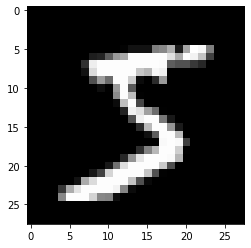

In [2]:
## MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

## in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

## in thử ảnh một ảnh
print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()

# Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

In [3]:

from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPool2D, BatchNormalization, ReLU, GlobalAveragePooling2D

class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_filters = [64, 64, 256],
                 kernel_regularizer=None,
                 down_sampling=False):
        
        super(ResidualBlock, self).__init__()
        self.n_filters = n_filters
        self.down_sampling = down_sampling
        self.kernel_regularizer = kernel_regularizer
    
    def get_config(self):
        config = super(ResidualBlock, self).get_config()
        config.update({
            'n_filters': self.n_filters,
            "down_sampling": self.down_sampling,
        })
        return config
    
    def build(self, input_shape):
        
        self.projection_shortcut = (int(input_shape[-1]) != self.n_filters[-1]) or self.down_sampling
        first_strides = [1,1]
        if self.down_sampling:
            first_strides = [2,2]
        
        self.main_conv1 = Convolution2D(filters=self.n_filters[0],
                                         kernel_size=[1,1],
                                         strides=first_strides,
                                         padding='same',
                                         kernel_regularizer=self.kernel_regularizer,
                                         activation=None)
        self.main_batch1 = BatchNormalization()
        self.main_relu1 = ReLU()

        self.main_conv2 = Convolution2D(filters=self.n_filters[1],
                                              kernel_size=[3,3],
                                              strides=[1,1],
                                              padding='same',
                                              kernel_regularizer=self.kernel_regularizer,
                                              activation=None)
        self.main_batch2 = BatchNormalization()
        self.main_relu2 = ReLU()


        self.main_conv3 = Convolution2D(filters=self.n_filters[2],
                                        kernel_size=[1,1],
                                        strides=[1,1],
                                        padding='same',
                                        kernel_regularizer=self.kernel_regularizer,
                                        activation=None)
        self.main_batch3 = BatchNormalization()

        if self.projection_shortcut:
            self.shortcut_conv = Convolution2D(filters=self.n_filters[2],              ### N_FILETERS bằng N_FILTERS của output
                                                        kernel_size=[1,1],          ### KERNEL_SIZE = [1,1]
                                                        strides=first_strides,      ### STRIDES: giống STRIDES của conv đầu
                                                        padding='same',
                                                        kernel_regularizer=self.kernel_regularizer,
                                                        activation=None)
            self.shortcut_batch = BatchNormalization()

        self.main_relu3 = ReLU()

    def call(self, inputs):
        
        main_conv1 = self.main_conv1(inputs)
        main_batch1 = self.main_batch1(main_conv1)
        main_relu1 = self.main_relu1(main_batch1)
        
        main_conv2 = self.main_conv2(main_relu1)
        main_batch2 = self.main_batch2(main_conv2)
        main_relu2 = self.main_relu2(main_batch2)

        main_conv3 = self.main_conv3(main_relu2)
        main_batch3 = self.main_batch3(main_conv3)
        
        if self.projection_shortcut:
            shortcut_conv = self.shortcut_conv(inputs)
            shortcut_batch = self.shortcut_batch(shortcut_conv)
            
            shortcut = shortcut_batch
        else:
            shortcut = inputs

        main_add = main_batch3 + shortcut

        main_relu3 = self.main_relu3(main_add)
        return main_relu3

In [4]:
def plot_history(history, nEpoch):
    # Plot loss and accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(nEpoch)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.tight_layout()
    plt.show()

In [5]:
from keras.regularizers import l2
l2_regularizer_rate = 0.0001

## Tạo lớp input kích thước (None, 28, 28, 1)
inputs = keras.layers.Input(shape=(28,28,1))

### Block 1
conv1 = Convolution2D(filters=64,
                      kernel_size=[7,7],
                      strides=[2,2],
                      padding='same',
                      kernel_regularizer=l2(l2_regularizer_rate),
                      activation=None)(inputs)

batch1 = BatchNormalization()(conv1)        

relu1 = ReLU()(batch1)

maxpool1 = MaxPool2D(pool_size=[3,3],
                     strides=[2,2])(relu1)

### Block 2

res2_1 = ResidualBlock(n_filters=[64, 64, 256],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(maxpool1)

res2_2 = ResidualBlock(n_filters=[64, 64, 256],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_1)
res2_3 = ResidualBlock(n_filters=[64, 64, 256],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_2)

### Block 3

res3_1 = ResidualBlock(n_filters=[128, 128, 512],
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res2_3)
res3_2 = ResidualBlock(n_filters=[128, 128, 512],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_1)
res3_3 = ResidualBlock(n_filters=[128, 128, 512],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_2)
res3_4 = ResidualBlock(n_filters=[128, 128, 512],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_3)

### Block 4

res4_1 = ResidualBlock(n_filters=[256, 256, 1024],
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res3_4)
res4_2 = ResidualBlock(n_filters=[256, 256, 1024],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_1)
res4_3 = ResidualBlock(n_filters=[256, 256, 1024],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_2)
res4_4 = ResidualBlock(n_filters=[256, 256, 1024],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_3)
res4_5 = ResidualBlock(n_filters=[256, 256, 1024],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_4)
res4_6 = ResidualBlock(n_filters=[256, 256, 1024],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_5)

### Block 5

res5_1 = ResidualBlock(n_filters=[512, 512, 2048],
                       down_sampling=True,
                       kernel_regularizer=l2(l2_regularizer_rate))(res4_6)
res5_2 = ResidualBlock(n_filters=[512, 512, 2048],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res5_1)
res5_3 = ResidualBlock(n_filters=[512, 512, 2048],
                       down_sampling=False,
                       kernel_regularizer=l2(l2_regularizer_rate))(res5_2)


### Block Output

avage_pool = GlobalAveragePooling2D()(res5_3)

softmax = Dense(units=10, activation='softmax')(avage_pool)

In [6]:
model = keras.models.Model(inputs=inputs, outputs=softmax)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
    

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        3200      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 64)          0         
_________________________________________________________________
residual_block (ResidualBloc (None, 6, 6, 256)         76928     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 6, 6, 256)         71552 

In [7]:
mc = tf.keras.callbacks.ModelCheckpoint(
            filepath='epoch: {epoch:02d}.hdf5',
            monitor="val_loss",
            verbose=0,
            save_best_only=False,
            mode='min'
)
BATCH_SIZE = 512
nEpoch = 70

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=nEpoch,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])

Epoch 1/70
106/106 [==============================] - 83s 383ms/step - loss: 3.4549 - accuracy: 0.4676 - val_loss: 4.1954 - val_accuracy: 0.0987
Epoch 2/70
106/106 [==============================] - 35s 326ms/step - loss: 2.3944 - accuracy: 0.7710 - val_loss: 4.1749 - val_accuracy: 0.1562
Epoch 3/70
106/106 [==============================] - 35s 326ms/step - loss: 2.0541 - accuracy: 0.8757 - val_loss: 4.0533 - val_accuracy: 0.2290
Epoch 4/70
106/106 [==============================] - 34s 325ms/step - loss: 1.8740 - accuracy: 0.9332 - val_loss: 3.4546 - val_accuracy: 0.4268
Epoch 5/70
106/106 [==============================] - 35s 326ms/step - loss: 1.7654 - accuracy: 0.9684 - val_loss: 2.5275 - val_accuracy: 0.7282
Epoch 6/70
106/106 [==============================] - 35s 326ms/step - loss: 1.7075 - accuracy: 0.9861 - val_loss: 2.2072 - val_accuracy: 0.8522
Epoch 7/70
106/106 [==============================] - 35s 326ms/step - loss: 1.6804 - accuracy: 0.9934 - val_loss: 2.1255 - val_ac

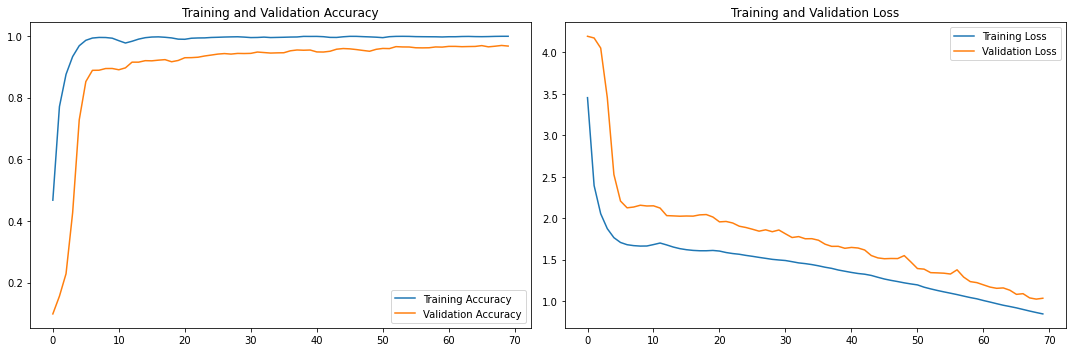

In [8]:
plot_history(history, nEpoch)